Our task is simple: unify and standardize ISO data sets into 1 dataframe
Here are the things we need to make sure we are doing:
- converting any timestamps or time associated data columns to datetime
- making sure that we are labeling where each sub data set comes from (e.g. ERCOT, SPP, etc.)
- making sure that we are able to apply transformations to datasets in 2 phases
    - phase 1: transformations on each ISO before merging to main df 
    - phase 2: transformations on the main df

In [33]:
# importing iso specific functions files so that we can apply transformations
from private_info import ercot_functions as efuncs

In [34]:
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datetime import date, datetime, timedelta

In [35]:
# allows us to define a date and from that assemble correct path refs
## today = date.today()  <-- only use this if you just pulled data today

# defining our date
today = "2025-05-17"  # should always be in the YYYY-MM-DD format

year_str = str(today)[:4]
month_str = str(today)[5:7]
day_str = str(today)[-2:]


print(today)
print(f'year string: {year_str}')
print(f'month string: {month_str}')
print(f'day string: {day_str}')

2025-05-17
year string: 2025
month string: 05
day string: 17


In [36]:
# loading in data that we have pulled
ercot_data = pl.read_csv(f'datasets/ercot_lmp_data/lmp_node_zone_hub_csv/{today}_lmp_node_zone_hub.csv')
spp_data = pl.read_csv(f'datasets/spp_lmp_data/LMP_By_SETTLEMENT_LOC/LMP_By_SETTLEMENT_LOC_{year_str}{month_str}{day_str}.csv')
nyiso_data = pl.read_csv(f'datasets/nyiso_lmp_data/realtime_zone/{year_str}{month_str}{day_str}.csv')
isone_data = pl.read_csv(f'datasets/isone_lmp_data/fiveminutelmp_csv/fiveminutelmp_{year_str}{month_str}{day_str}.csv')
caiso_data = pl.read_csv(f'datasets/caiso_lmp_data/lmp_csv_merged/{year_str}{month_str}{day_str}_lmp.csv')
pjm_data = pl.read_csv(f'datasets/pjm_lmp_data/rt_unverified_fivemin_lmps_csv/{month_str}-{day_str}-{year_str}.csv')
miso_data = pl.read_csv(f'datasets/miso_lmp_data/lmp_csv/{year_str}-{month_str}-{day_str}_lmp.csv')

In [37]:
# transforming our data sets before the main merge so that we can view it
ercot_df = efuncs.transform_ercot_data(ercot_df=ercot_data)
ercot_df.describe()

statistic,timestamp,repeatHourFlag,node_id,5min_lmp,iso_id,hour
str,str,f64,str,f64,str,f64
"""count""","""500000""",500000.0,"""500000""",500000.0,"""500000""",500000.0
"""null_count""","""0""",0.0,"""0""",0.0,"""0""",0.0
"""mean""","""2025-05-18 00:14:58.818480""",0.0,null,30.051929,null,11.616782
"""std""",null,null,null,23.372946,null,6.017352
"""min""","""2025-05-17 04:30:00""",0.0,"""7RNCHSLR_ALL""",-540.49,"""ERCOT""",0.0
"""25%""","""2025-05-17 14:15:00""",null,null,21.74,null,7.0
"""50%""","""2025-05-18 00:15:00""",null,null,25.53,null,12.0
"""75%""","""2025-05-18 10:20:00""",null,null,33.44,null,16.0
"""max""","""2025-05-18 20:10:00""",0.0,"""ZIER_SLR_ALL""",1186.32,"""ERCOT""",23.0


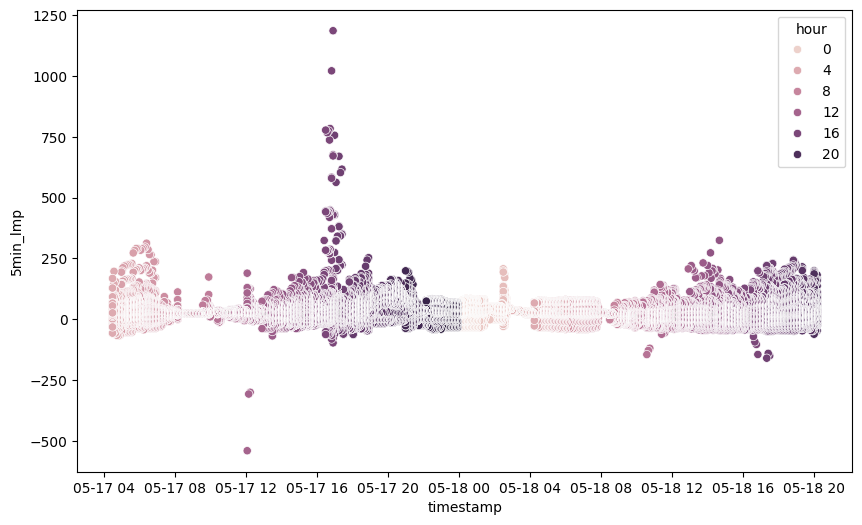

In [39]:
plt.figure(figsize=[10,6])
sns.scatterplot(data=ercot_df, x='timestamp', y='5min_lmp', hue='hour')
plt.show()

In [40]:
spp_data.describe()

statistic,Interval,GMTIntervalEnd,Settlement Location,Pnode,LMP,MLC,MCC,MEC
str,str,str,str,str,f64,f64,f64,f64
"""count""","""333960""","""333960""","""333960""","""333960""",333960.0,333960.0,333960.0,333960.0
"""null_count""","""0""","""0""","""0""","""0""",0.0,0.0,0.0,0.0
"""mean""",null,null,null,null,23.45806,-0.666436,-3.742679,27.867176
"""std""",null,null,null,null,61.709174,2.418941,56.529632,31.439057
"""min""","""05/17/2025 00:05:00""","""05/17/2025 05:05:00""","""AEC""","""ADA1_DDR""",-437.0148,-40.1729,-497.2159,-2.6125
"""25%""",null,null,null,null,5.9434,-1.1775,-8.5298,9.9957
"""50%""",null,null,null,null,18.7434,-0.3359,-2.6876,21.1234
"""75%""",null,null,null,null,29.7521,0.1702,0.878,34.9596
"""max""","""05/17/2025 23:55:00""","""05/18/2025 04:55:00""","""YAD""","""WWO1_DDR""",1547.0656,59.2468,1265.4446,223.1325


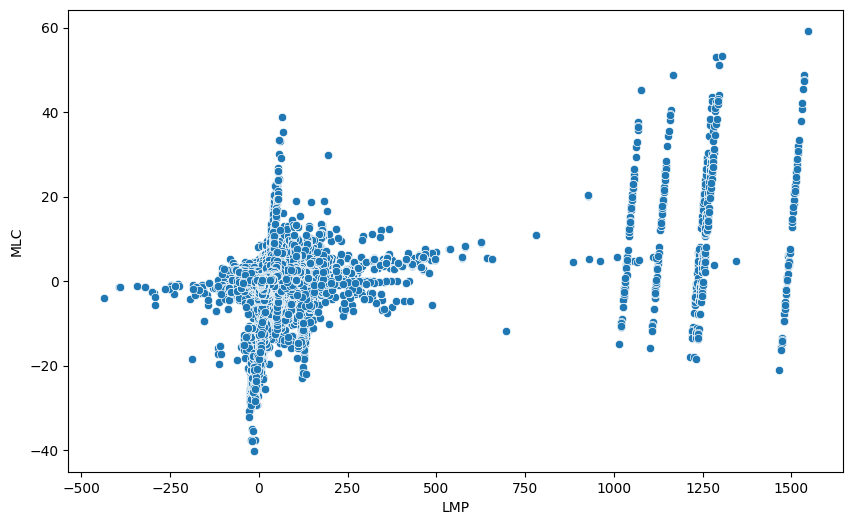

In [46]:
plt.figure(figsize=[10,6])

lmp_v_mlc = sns.scatterplot(data=spp_data, x='LMP', y='MLC')

plt.show()

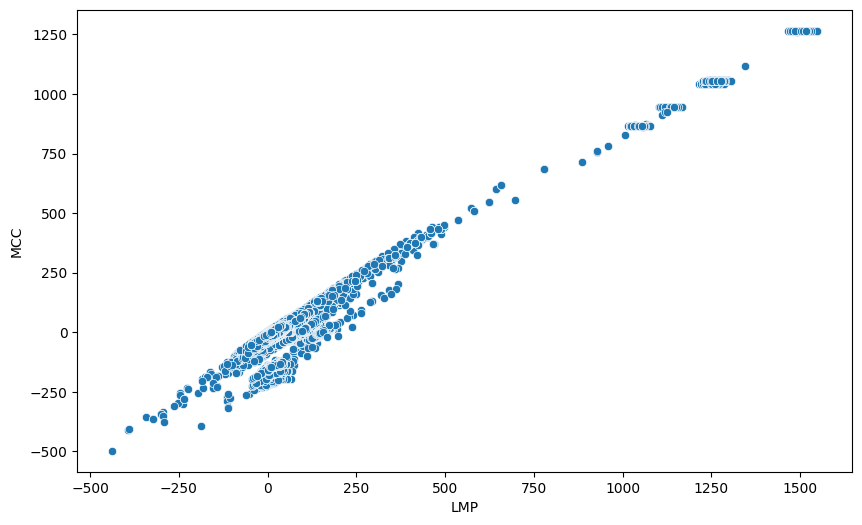

In [47]:
plt.figure(figsize=[10,6])

lmp_v_mcc = sns.scatterplot(data=spp_data, x='LMP', y='MCC')

plt.show()

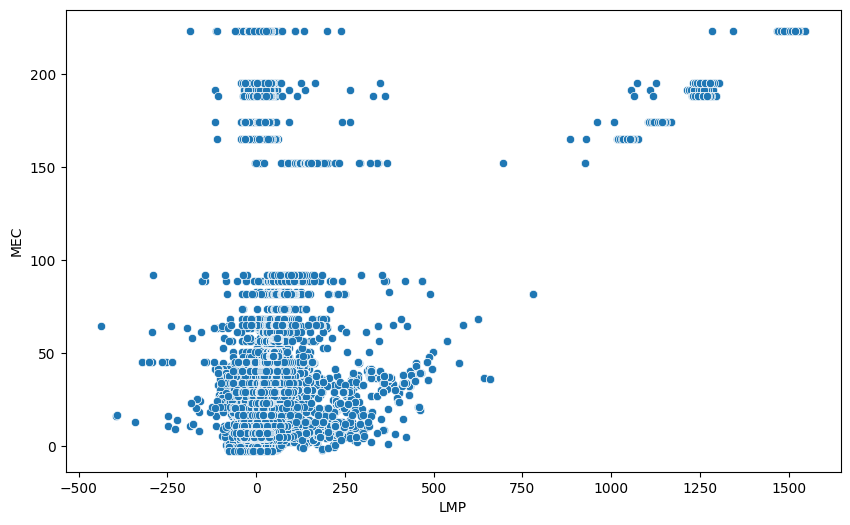

In [48]:
plt.figure(figsize=[10,6])

lmp_v_mec = sns.scatterplot(data=spp_data, x='LMP', y='MEC')

plt.show()